In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

import scipy.io
import numpy as np


#Funcion que genera los labels
def LabelGenerator (categories, instances_Per_Cat):
    
    cont = 0;
    eyed = np.eye((categories))
    
    Labels = np.zeros((categories * instances_Per_Cat,3))
    
    for a in np.arange(categories):
        for b in np.arange(instances_Per_Cat):
            Labels[cont,:] = eyed[a,:]
            cont = cont+1
            
            
    return Labels
  
#Funcion que abre los archivos .mat
def LoadMatFiles (FilesPaths,StructNames, CAT, WIN_PER_CAT, DATA_SIZE):
    
    data = np.zeros((CAT*WIN_PER_CAT,DATA_SIZE[0],DATA_SIZE[1],1))
     
    for a,b,c in zip(FilesPaths,StructNames,range(CAT)):
        data_prov =  scipy.io.loadmat(a)
        data[c*WIN_PER_CAT:(c+1)*WIN_PER_CAT,:,:,0] = data_prov[b]       
        
    return data

#Funcion que divide los datos para evaluacion y entrenamiento
def TrainTestSplit(test_size,cat,win_per_cat):
    
    testRSize = int(np.floor(win_per_cat*test_size))
    trainRSize = int(np.ceil(win_per_cat*(1-test_size)))
    trainSet = np.zeros((3*trainRSize))
    testSet = np.zeros((3*testRSize))
    
    x = np.arange(win_per_cat).reshape(win_per_cat)
    np.random.shuffle(x)
    
    for a in np.arange(cat):           
        trainSet[trainRSize*a : trainRSize*(a+1)] = x[0:trainRSize] + win_per_cat * a
        testSet[testRSize*a: testRSize*(a+1)] = x[trainRSize:win_per_cat] + win_per_cat * a
        
    return np.array(trainSet,'int'), np.array(testSet,'int')

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model


#Funcion que grafica la matriz de confusion
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Default',
                          cmap=plt.cm.YlOrRd):

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(u'Matriz de confusión normalizada')
    else:
        print(u'Matriz de confusión, sin normalización')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, label=u'Número de casos')
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Verdadero',
           xlabel=u'Predicción')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#Funcion que grafica la curva de aprendizaje
def LearningRate(data_train):
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title
    plt.plot(data_train,'r')
    ax.set_title(u'Curva de aprendizaje (parametrización)',fontsize=17)
    ax.set_ylabel('Exactitud', fontsize=14)
    ax.set_xlabel(u'Época', fontsize=14)
    ax.grid(True)
    plt.show()


#CNN para el analisis temporal, power spectrum y transformada Wavelet
def Net(input_size):
    
    input_1 = Input(input_size)
    conv1 = Conv2D(8, (5,5), activation = 'relu')(input_1)
    pool1 = MaxPooling2D(pool_size=(2, 2),strides = None, padding='valid')(conv1)
    conv2 = Conv2D(16, (3,3), activation = 'relu')(pool1)
    #conv3 = Conv2D(16, (2,2), activation = 'relu')(conv2)
    #pool2 = MaxPooling2D(pool_size=(2, 2),strides = None, padding='valid')(conv3)
    out1 = Flatten()(conv2)
    
    #((10-2)/2-1-1)/2 = 1
    #((173-2)/2-1-1)/2 = 41
    out2 = Dense(100, activation='sigmoid', use_bias=True, kernel_initializer='zeros', bias_initializer='zeros')(out1)
    out3 = Dense(3, activation='softmax', use_bias=True, kernel_initializer='zeros', bias_initializer='zeros')(out2)  
    
    model = Model(inputs = input_1, output = out3)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])    
    model.summary()
    
    return model
  

#CNN para los parametros estadisticos
def Net2(input_size):
    
    input_1 = Input(input_size)
    conv1 = Conv2D(8, (3,3), activation = 'relu')(input_1)
    pool1 = MaxPooling2D(pool_size=(2, 2),strides = None, padding='valid')(conv1)
    conv2 = Conv2D(16, (1,1), activation = 'relu')(pool1)
    out1 = Flatten()(conv2)
    
    #((5-1)/2-1) = 1
    #((7-1)/2-1) = 2
    out2 = Dense(10, activation='sigmoid', use_bias=True, kernel_initializer='zeros', bias_initializer='zeros')(out1)
    out3 = Dense(3, activation='softmax', use_bias=True, kernel_initializer='zeros', bias_initializer='zeros')(out2)  
    
    model = Model(inputs = input_1, output = out3)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])    
    model.summary()
    
    return model


In [ ]:
#Rutas de los archivos a cargar
FilesPaths = ['/content/drive/My Drive/Normal.mat','/content/drive/My Drive/InterIctal.mat','/content/drive/My Drive/Ictal.mat']
StructNames = ['NormalStat','InterStat','IctalStat']
CAT = 3;                                              #Número de clases
WIN_PER_CAT = 200;                                    #Casos por clase
DATA_SIZE = [5,7];                                    #Tamaño de matrices 10*173 o 5*7


In [ ]:
#Generar los labels 
#     1 0 0 = InterIctal
#     0 1 0 = PreIctal
#     0 0 1 = Ictal
labels = LabelGenerator(CAT, WIN_PER_CAT)

#Cargar los archivos .mat
Data = LoadMatFiles(FilesPaths,StructNames, CAT, WIN_PER_CAT, DATA_SIZE)
Data = (Data-np.min(Data))/(np.max(Data)-np.min(Data)) #Normalización tipo min-max

#Train Test Split 
trainIndex, testIndex = TrainTestSplit(0.50,CAT,WIN_PER_CAT)

In [89]:
#Modelo de la CNN
model = Net2((DATA_SIZE[0],DATA_SIZE[1],1)) #Creación del objeto tipo CNN

#Entrenamiento de la CNN
history = model.fit(Data[trainIndex,:,:,:], labels[trainIndex,:], steps_per_epoch=20, epochs=200, shuffle = True) #validation_split=0.33, validation_steps=1)

#Evaluación de la CNN
results = model.predict(Data[testIndex,:,:,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 5, 7, 1)           0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 3, 5, 8)           80        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 2, 8)           0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 1, 2, 16)          144       
_________________________________________________________________
flatten_17 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 33        
Total para

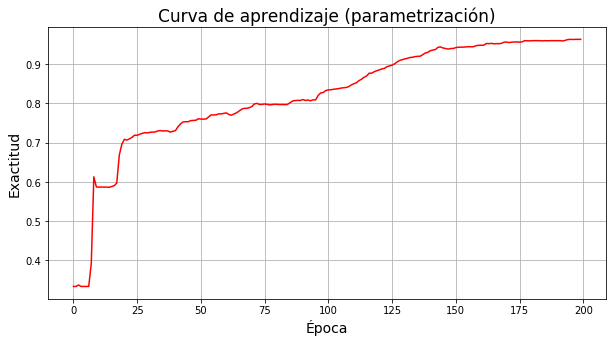

<Figure size 432x288 with 0 Axes>

In [90]:
#Gráfica de la curva de aprendizaje
LearningRate(history.history['acc'])
plt.savefig('/content/drive/My Drive/LearnCurve_StatParameters_50-50.jpg')


Matriz de confusión, sin normalización
[[95  5  0]
 [ 7 92  1]
 [ 0  2 98]]


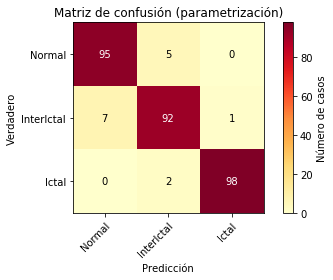

In [91]:
plot_confusion_matrix(np.array(np.argmax(labels[testIndex,:],axis=1),'int32'), np.array(np.argmax(results,axis=1),'uint8'), classes=['Normal', 'InterIctal','Ictal'],
                      title=u'Matriz de confusión (parametrización)',normalize = False)
plt.savefig('/content/drive/My Drive/Confusion_StatParameters_50-50.jpg')